# Convolutional Neural Networks for Jet-Images
Author: Javier Duarte

## Load numpy arrays
Here, we load the numpy arrays containing the 4D tensors of "jet-images" (see https://arxiv.org/pdf/1511.05190.pdf)

In [1]:
import h5py

h5f = h5py.File("data/jet_images.h5", "r")

jet_images_dict = {}
jet_images_dict['QCD'] = h5f['QCD'][()]
jet_images_dict['TT'] = h5f['TT'][()]

h5f.close()

/cvmfs/cms.cern.ch/slc7_amd64_gcc700/external/py2-pippkgs_depscipy/3.0-omkpbe4/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# 4D tensor (tensorflow backend)
# 1st dim is jet index
# 2nd dim is eta bin
# 3rd dim is phi bin
# 4th dim is pt value (or rgb values, etc.)
print(jet_images_dict['QCD'].shape)
print(jet_images_dict['TT'].shape)

(3305, 30, 30, 1)
(1821, 30, 30, 1)


## Plotting jet-images
Let's plot some jet-images (individual jets and averaged over all jets)

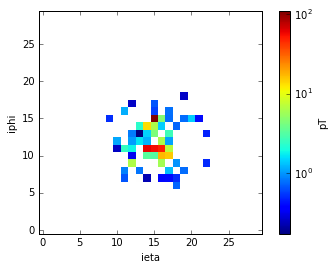

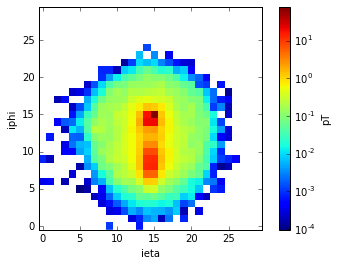

In [3]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
%matplotlib inline

# plot one W jet
i = 7
plt.figure('W') 
plt.imshow(jet_images_dict['TT'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average W jet
ave_jet_image_TT = np.sum(jet_images_dict['TT'][:,:,:,0],axis=0)/len(jet_images_dict['TT'])
plt.figure('W') 
plt.imshow(ave_jet_image_TT.T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

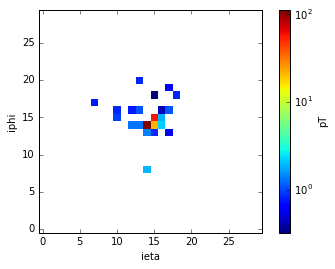

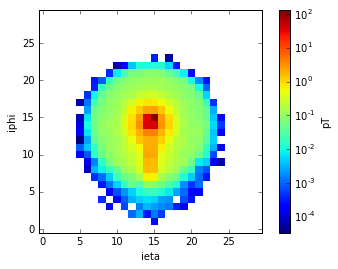

In [4]:
# plot one QCD jet
i = 7
plt.figure() 
plt.imshow(jet_images_dict['QCD'][i,:,:,0].T, norm=mpl.colors.LogNorm(), origin='lower', interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

# plot average QCD jet
ave_jet_image_QCD = np.sum(jet_images_dict['QCD'][:,:,:,0],axis=0)/len(jet_images_dict['QCD'])
plt.figure() 
plt.imshow(ave_jet_image_QCD.T, norm=mpl.colors.LogNorm(), origin='lower',  interpolation='none')
cbar = plt.colorbar()
cbar.set_label('pT')
plt.xlabel('ieta')
plt.ylabel('iphi')
plt.show()

## Define our convolutional model

In [5]:
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dropout, Dense, BatchNormalization, Concatenate
from keras.regularizers import l1,l2
nx = 30
ny = 30
input_layer = Input(shape=(nx, ny, 1), name='input')
layer = BatchNormalization(momentum=0.6, name='batchnorm_0')(input_layer)
layer = Conv2D(32, (11, 11), strides=(1, 1), padding='same', activation='relu', name='conv2d_1', kernel_regularizer=l2(0.01))(layer)
layer = BatchNormalization(momentum=0.6, name='batchnorm_1')(layer)
layer = MaxPool2D(pool_size=(2, 2), name='maxpool2d_1')(layer)
layer = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv2d_2', kernel_regularizer=l2(0.01))(layer)
layer = BatchNormalization(momentum=0.6, name='batchnorm_2')(layer)
layer = MaxPool2D(pool_size=(3, 3), name='maxpool2d_2')(layer)
layer = Conv2D(32, (3, 3), strides=(1, 1), padding='same', activation='relu', name='conv2d_3', kernel_regularizer=l2(0.01))(layer)
layer = BatchNormalization(momentum=0.6, name='batchnorm_3')(layer)
layer = MaxPool2D(pool_size=(3, 3), name='maxpool2d_3')(layer)
layer = Flatten(name='flatten')(layer)]
layer = Dense(64, activation='relu', name='dense', kernel_regularizer=l2(0.01))(layer)
output_layer = Dense(1, activation='sigmoid', name='output', kernel_regularizer=l2(0.01))(layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 30, 30, 1)         0         
_________________________________________________________________
batchnorm_0 (BatchNormalizat (None, 30, 30, 1)         4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        3904      
_________________________________________________________________
batchnorm_1 (BatchNormalizat (None, 30, 30, 32)        128       
_________________________________________________________________
maxpool2d_1 (MaxPooling2D)   (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 32)        9248      
_________________________________________________________________
batchnorm_2 (BatchNormalizat (None, 15, 15, 32)        128       
__________

## Split dataset

In [6]:
jet_images = np.concatenate([jet_images_dict['TT'],
                             jet_images_dict['QCD']])
jet_labels = np.concatenate([np.ones(len(jet_images_dict['TT'])), 
                             np.zeros(len(jet_images_dict['QCD']))])

X = jet_images
Y = jet_labels

from sklearn.model_selection import train_test_split
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.2, random_state=7)

print 'number of W jets for training/validation: %i'%np.sum(Y_train_val==1)
print 'number of QCD jets for training/validation: %i'%np.sum(Y_train_val==0)

print 'number of W jets for testing: %i'%np.sum(Y_test==1)
print 'number of QCD jets for testing: %i'%np.sum(Y_test==0)

from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

number of W jets for training/validation: 1459
number of QCD jets for training/validation: 2641
number of W jets for testing: 362
number of QCD jets for testing: 664


## Run training
Here, we run the training.

In [7]:
# Train classifier
history = model.fit(X_train_val, Y_train_val, epochs=200, batch_size=1024, verbose=1, callbacks=[early_stopping], validation_split=0.25)

Train on 3075 samples, validate on 1025 samples
Epoch 1/200
3075/3075 [==============================] - 5s 1ms/step - loss: 1.5943 - acc: 0.7522 - val_loss: 1.4311 - val_acc: 0.8644
Epoch 2/200
3075/3075 [==============================] - 3s 1ms/step - loss: 1.3954 - acc: 0.8917 - val_loss: 1.3471 - val_acc: 0.9044
Epoch 3/200
3075/3075 [==============================] - 3s 1ms/step - loss: 1.3353 - acc: 0.8995 - val_loss: 1.3182 - val_acc: 0.9044
Epoch 4/200
3075/3075 [==============================] - 3s 1ms/step - loss: 1.3003 - acc: 0.9063 - val_loss: 1.2927 - val_acc: 0.9044
Epoch 5/200
3075/3075 [==============================] - 3s 1ms/step - loss: 1.2727 - acc: 0.9086 - val_loss: 1.2734 - val_acc: 0.9024
Epoch 6/200
3075/3075 [==============================] - 3s 1ms/step - loss: 1.2400 - acc: 0.9141 - val_loss: 1.2537 - val_acc: 0.9015
Epoch 7/200
3075/3075 [==============================] - 3s 1ms/step - loss: 1.2118 - acc: 0.9158 - val_loss: 1.2112 - val_acc: 0.9024
Epoch 8

Epoch 61/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.7180 - acc: 0.9018 - val_loss: 0.7308 - val_acc: 0.8956
Epoch 62/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.7135 - acc: 0.9005 - val_loss: 0.7349 - val_acc: 0.8985
Epoch 63/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.7043 - acc: 0.9002 - val_loss: 0.7194 - val_acc: 0.8927
Epoch 64/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.6993 - acc: 0.8972 - val_loss: 0.7894 - val_acc: 0.8780
Epoch 65/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.7374 - acc: 0.8852 - val_loss: 0.8499 - val_acc: 0.8751
Epoch 66/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.6912 - acc: 0.9021 - val_loss: 0.7121 - val_acc: 0.8898
Epoch 67/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.7130 - acc: 0.9024 - val_loss: 0.7100 - val_acc: 0.8898
Epoch 68/200
3075/3075 [========================

3075/3075 [==============================] - 3s 1ms/step - loss: 0.5308 - acc: 0.9125 - val_loss: 0.5559 - val_acc: 0.8985
Epoch 122/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.5242 - acc: 0.9102 - val_loss: 0.5559 - val_acc: 0.8946
Epoch 123/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.5210 - acc: 0.9109 - val_loss: 0.5499 - val_acc: 0.8976
Epoch 124/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.5171 - acc: 0.9119 - val_loss: 0.5463 - val_acc: 0.8966
Epoch 125/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.5139 - acc: 0.9128 - val_loss: 0.5454 - val_acc: 0.8966
Epoch 126/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.5120 - acc: 0.9138 - val_loss: 0.5503 - val_acc: 0.8956
Epoch 127/200
3075/3075 [==============================] - 3s 1ms/step - loss: 0.5118 - acc: 0.9122 - val_loss: 0.5642 - val_acc: 0.8956
Epoch 128/200
3075/3075 [==============================

## Plot performance
Here, we plot the history of the training and the performance in a ROC curve

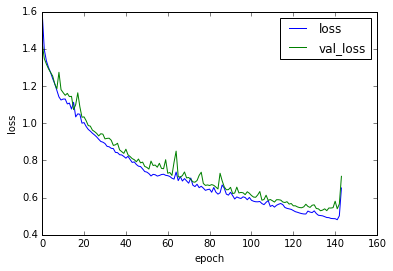

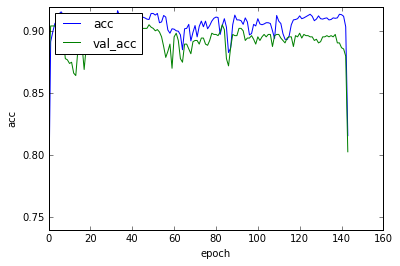

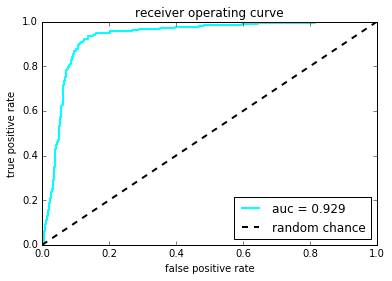

In [8]:
# plot loss vs epoch
plt.figure()
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')

# plot accuracy vs epoch
plt.figure()
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend(loc="upper left")
plt.xlabel('epoch')
plt.ylabel('acc')

# Plot ROC
Y_predict = model.predict(X_test)
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(Y_test, Y_predict)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, lw=2, color='cyan', label='auc = %.3f' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='random chance')
plt.xlim([0, 1.0])
plt.ylim([0, 1.0])
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('receiver operating curve')
plt.legend(loc="lower right")
plt.show()